## Blob classification

- Remove border BLOBs
- Cleaning using morphological operations
- Visualize found labels
- Exploring BLOB features: blob circularuty, area and perimeter
- cell_counting function (summary of all the worksheet)


In [ ]:
# Binary image from original image

in_dir = "data/"
im_org = io.imread(f"{in_dir}lego_4_small.png")
im_gray = color.rgb2gray(im_org)
thres = threshold_otsu(im_gray)
im_bin = im_gray < thres

show_comparison(im_org, im_bin, "Binary image")

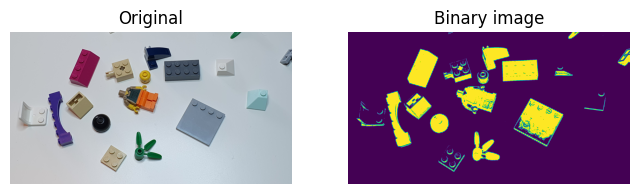


In [ ]:
# Remove border BLOBs

im_process = segmentation.clear_border(im_bin)

In [ ]:
# Cleaning using morphological operations
# In order to remove remove noise and close holes, you should do a morphological closing followed by a morphological opening
# with a disk shaped structuring element with radius 5

footprint = morphology.disk(5)
im_process = morphology.binary_closing(im_process, footprint)
im_open = morphology.binary_opening(im_process, footprint)

In [ ]:
# Find labels
# The actual connected component analysis / BLOB analysis is performed using measure.label

label_img = measure.label(im_open)
n_labels = label_img.max()
print(f"Number of labels: {n_labels}")

In [ ]:
# Visualize found labels
# We can use the function label2rbg to create a visualization of the found BLOBS.

im_blob = label2rgb(label_img)
show_comparison(im_org, im_blob, "BLOBS")

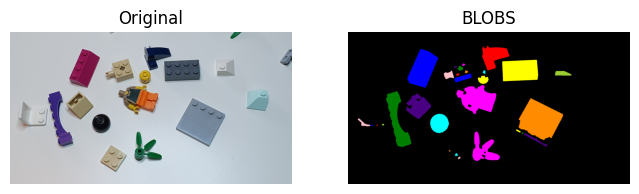


In [ ]:
# Compute BLOB features
# It is possible to compute a wide variety of BLOB features using the measure.regionprops function

region_props = measure.regionprops(label_img)
areas = np.array([prop.area for prop in region_props])
plt.hist(areas, bins=50)
plt.show()

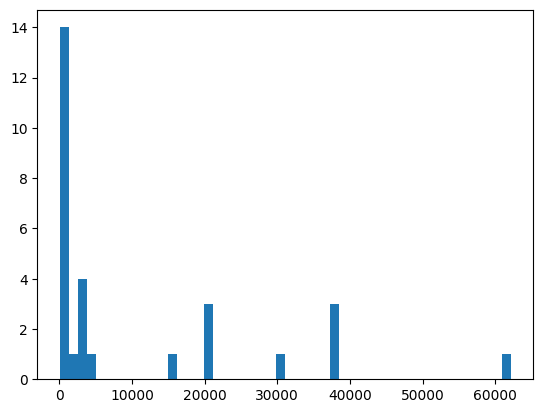


The goal of this part of the exercise, is to create a small program that can automatically count the number of cell nuclei in an image.


In [1]:
## cell image
# avoid bin with value 0 due to the very large number of background pixels
plt.hist(img_gray.ravel(), bins=256, range=(1, 100))
io.show()

thres = threshold_otsu(img_gray)
img_bin = img_gray > thres
show_comparison(img_gray, img_bin, "binary")

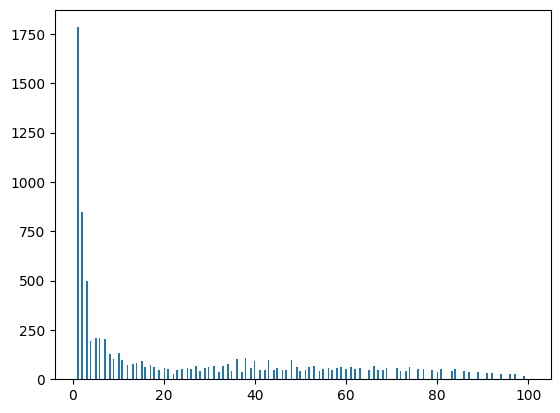
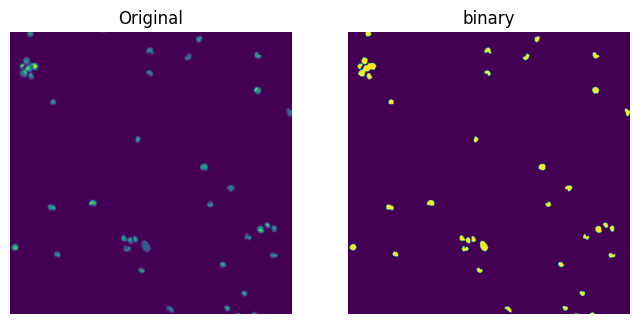


In [ ]:
# Select a minimum and maximum allowed area and use the following to visualise the result:

min_area = 10
max_area = 150

# Create a copy of the label_img
label_img_filter = label_img
for region in region_props:
    # Find the areas that do not fit our criteria
    if region.area > max_area or region.area < min_area:
        # set the pixels in the invalid areas to background
        for cords in region.coords:
            label_img_filter[cords[0], cords[1]] = 0
# Create binary image from the filtered label image
i_area = label_img_filter > 0
show_comparison(img_small, i_area, "Found nuclei based on area")

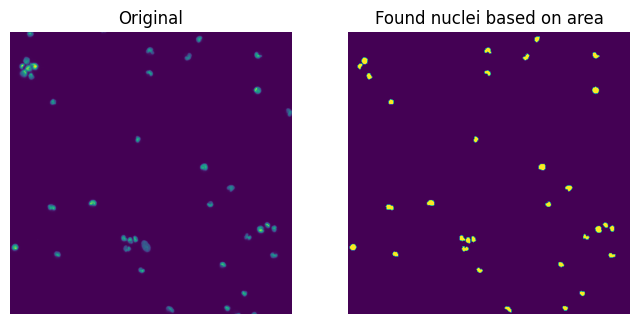


In [ ]:
def circularity(area, perimeter):
    """
    You may get values larger than 1 because
    we are in a "discrete" (pixels) domain. Check:

    CIRCULARITY OF OBJECTS IN IMAGES, Botterma, M.J. (2000)
    https://core.ac.uk/download/pdf/14946814.pdf
    """
    f_circ = (4 * np.pi * area) / (perimeter**2)
    return f_circ


circs = circularity(areas, perimeters)

In [ ]:
def cell_counting(img_gray, min_area=10, max_area=150, min_circ=0.7):
    # Binarization
    thres = threshold_otsu(img_gray)
    img_bin = img_gray > thres
    img_c_b = segmentation.clear_border(img_bin)

    # Label image
    label_img = measure.label(img_c_b)

    # Extract properties
    region_props = measure.regionprops(label_img)

    # Number of blobs
    n_nuclei = len(region_props)

    # Filter the label image
    label_img_filter = label_img.copy()
    for region in region_props:
        circ = circularity(region.area, region.perimeter)
        # Find the areas that do not fit our criteria
        if region.area > max_area or region.area < min_area or circ < min_circ:
            # set the pixels in the invalid areas to background
            n_nuclei = n_nuclei - 1
            for cords in region.coords:
                label_img_filter[cords[0], cords[1]] = 0

    # Create binary image from the filtered label image
    i_area = label_img_filter > 0

    return i_area, n_nuclei

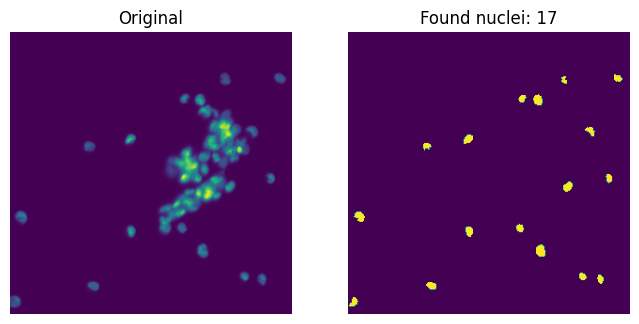
